# Create Figure 1 for PTEN

This notebook creates a histogram that shows the different PTEN mutations found in 9 cancers.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import plot_utils as ut

SyntaxError: f-string expression part cannot include a backslash (pathway_utils.py, line 576)

# Step 1: Create data frames with Mutation Types

For each cancer type, create a data frame that has the mutation type for each sample.

First, load in the cancer data sets from cptac.

In [5]:
en = cptac.Endometrial()
hn = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
c = cptac.Ccrcc()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()

cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 8)


Second, call get_geneotype_all_vars for PTEN for each cancer type. This returns a df with columns for Mutation (type of mutation), Location (location of the mutation), and Mutation_Status (wildtype or mutation count).

In [26]:
gene = "PTEN"

In [27]:
endo = en.get_genotype_all_vars(gene)
gbm = g.get_genotype_all_vars(gene)
hnscc = hn.get_genotype_all_vars(gene)
ovar = o.get_genotype_all_vars(gene)
cc = c.get_genotype_all_vars(gene)
colon = col.get_genotype_all_vars(gene)
ld = l.get_genotype_all_vars(gene)
lscc = ls.get_genotype_all_vars(gene)
brca = b.get_genotype_all_vars(gene)

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 383)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for

# Step 2: Match Mutation Labels

The Colon dataset labeled their mutations slightly differently. Nonsynonymous snv in this case is a missense mutation. Nonframeshift insertion was changed to match In_Frame_Ins. Frameshift deletion was canged to match Frame_Shift_Del.

In [28]:
colon["Mutation"] = colon['Mutation'].replace(['nonsynonymous SNV'], 'Missense_Mutation')

colon["Mutation"] = colon['Mutation'].replace(['nonframeshift insertion'], 'In_Frame_Ins')

colon["Mutation"] = colon['Mutation'].replace(['frameshift deletion'], 'Frame_Shift_Del')

The get_genotype_all_var function created the No_Mutation label when no somatic mutations were found for PTEN in the Luad dataset. This is the same as Wildtype_Tumor. 

In [29]:
ld["Mutation"] = ld['Mutation'].replace(['No_Mutation'], 'Wildtype_Tumor')

In [34]:
def plot_mutations(dflist = None, names_of_df=None):
    number_of_df = len(dflist)
    
    allLabels = []
    for df in dflist:
        #get the labels for each and make a combined label that they'll all use
        mutation = df["Mutation"]
        labels = set(mutation)
        allLabels.append(labels)

    
    flat_list = [item for sublist in allLabels for item in sublist]
    all_labels = list(set(flat_list))
    all_labels.sort()
    allLabels = all_labels
    
#     For each df, add na to their labels if it doesn't exist in all_labels
    labels_for_each_df = []
    frequencies_for_each_df = []
    for df in dflist:
        mutation = df["Mutation"].tolist()
        mutationlist = list(set(mutation))
        mutationlist.sort()
        ordered_mut_list = []
        match = True
        mutPosition = 0
        
        for position in range(len(all_labels)):
            try:
                
                if mutationlist[mutPosition] == all_labels[position]:
                    ordered_mut_list.append(mutationlist[mutPosition])
                    mutPosition += 1

                else:
                    ordered_mut_list.append("na")

            except IndexError:  
                ordered_mut_list.append("na")
       
        
        labels_for_each_df.append(ordered_mut_list)

        #get the freq of each mutation type
        freq = []
        for mutation_type in ordered_mut_list:
            freq.append(mutation.count(mutation_type))

        PercentFreq = [x*100 / sum(freq) for x in freq]
        frequencies_for_each_df.append(PercentFreq)
        
        
#     import pdb; pdb.set_trace()
    #Now plot it using arrays
    width = 0.1
    x = np.arange(len(allLabels))
    a4_dims = (13, 10) #dimensions for bigger plot
    fig, ax = plt.subplots(figsize=a4_dims)
    for position in range(0, number_of_df):
        r = ax.bar(x+(width*position), frequencies_for_each_df[position], width,label=names_of_df[position], alpha=.5, linewidth=0)



    ax.set_ylabel('Percent Sample')
    ax.set_title('Mutation Frequency and Effect')
    ax.set_xticks(x)
    ax.set_xticklabels(allLabels)
    ax.legend()
    



    fig.tight_layout()
    plt.setp(ax.get_xticklabels(),rotation='vertical')
    plt.show()
    
    #save fig
    fig.savefig("Step_1_PTEN.png", bbox_inches="tight")
    

# Step 3: Create Figure

Create a list of the mutation data frames. Create a list of cancer names for the figure legend. Call the plot_mutations function.

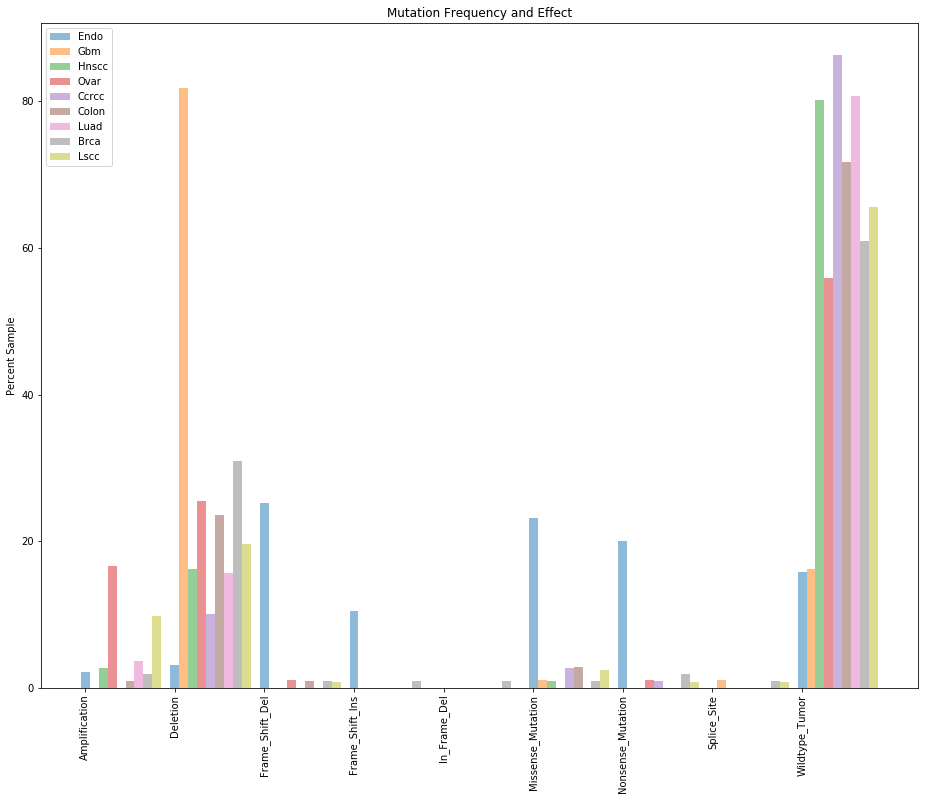

In [35]:
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, lscc, brca]
names = ['Endo', 'Gbm', 'Hnscc', 'Ovar', 'Ccrcc', 'Colon', 'Luad', 'Brca', 'Lscc']
plot_mutations(dfs, names)